Pada tugas ini, akan dilakukan klasifikasi gambar bunga dengan multilayer perceptron (MLP). Terdapat tiga kelas bunga yaitu daisy, dandelion, dan sunflower, dan terdapat 100 gambar untuk setiap kelas dengan ukuran 320x240 pixels.

# Functions

Pertama, akan didefinisikan terlebih dahulu fungsi-fungsi yang akan digunakan.

In [2]:
# import library yang digunakan
import os
import cv2
import numpy as np
from math import log10
import random as rand
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Fungsi load dataset

In [3]:
def load(path: str, dim: tuple) -> list:
  """
  # Load data (array of image) dari link external (google drive).
  ---

  parameter:
    path : string, path untuk menuju image
    dim  : tuple of int, ukuran gambar yang diinginkan
  
  return: array of images yang memiliki ukuran pasti
  """

  if type(path) != str:
    raise TypeError("parameter pertama harus dalam bentuk string.")
  if type(dim) != tuple or len(dim) == 0:
    raise TypeError("parameter kedua harus mempunyai nilai tuple yang berisi int.")
  if type(dim[0]) != int or len(dim) != 2:
    raise TypeError("isi dalam parameter pertama harus dalam bentuk int dengan length 2.")

  images = []
  files = os.listdir(path)
  for i in range(len(files)):
    img = cv2.imread(path + "/" + files[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    images.append(img)
  return images

### Fungsi visualisasi dataset

In [4]:
def visualize_images(dataset, y, sd):
  """
  # Visualisasi gambar sampel dataset secara random
  ---

  parameter:
    dataset : list of graysacle images
    y       : kelas dataset
    sd      : random seed
    
  """
  plt.gray()
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 12))
  plt.suptitle('Visualisasi Sampel Dataset dan Kelasnya',fontsize=25)
  rand.seed(sd)   
  
  index = [rand.randint(0, len(dataset)) for x in range(9)]
  dt = np.array(dataset)
  dt = dt[index]
  target = np.array(y)
  target = target[index]
  
  for img, t, ax in zip(dt, target, axes.ravel()):
    ax.imshow(img)
    ax.set_xlabel(t, fontsize=18)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [5]:
def visualize_histogram(image, multiple=False):
  """
  # Generate Image Histogram dari gambar.
  ---
  Apabila terdapat banyak gambar, akan dibuat Image baru yang merupakan rata-
  rata dari gambar yang diberikan.

  parameter:
    image     : image(s) yang akan dibuat histogramnya.
    multiple  : True apabila image lebih dari satu.
    
  """
  if multiple:
    image = np.mean(np.array([arr for arr in image]), axis=0)
  
  cv2_imshow(image)
  
  intensitas_pixel=[]
  for row in range(image.shape[0]):
    for column in range(image.shape[1]):
      intensitas_pixel.append(image[row][column])

  plt.figure(figsize=(20,10))
  plt.hist(intensitas_pixel, bins=256) 
  plt.title("Image Histogram", fontsize=20)
  plt.xlabel("Intensitasi Pixel")
  plt.ylabel("Frekuensi")
  plt.xticks(np.arange(0, 255, 10)) 
  plt.show()

### Fungsi konversi gambar ke format grayscale

In [6]:
def convert_to_grayscale(images: list) -> list:
  """
  # Konversi gambar ke format grayscale.
  ---

  parameter:
    images : list image

  return: list images dalam format graysacle
  """

  if type(images) != list:
    raise TypeError("parameter pertama harus dalam bentuk list of images.")
  if not len(images):
    raise ValueError("list harus berisi.")
  if type(images[0]) != np.ndarray:
    raise TypeError("parameter pertama harus dalam bentuk numpy array.")

  new_images = []
  for image in images:
    new_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
  return new_images

### Fungsi flatten

In [7]:
def flatten(images: list) -> list:
  """
  # Mengubah image dari 2 dimensi menjadi 1 dimensi.
  ---

  parameter:
    imgs : list images

  return: list terdiri dari array 1 dimensi (image yang telah di-flattened)
  """

  if type(images) != list:
    raise TypeError("parameter pertama harus dalam bentuk array of images.")
  if not len(images):
    raise ValueError("array harus berisi.")
  if type(images[0]) != np.ndarray:
    raise TypeError("parameter pertama harus dalam bentuk numpy array.")

  flatten = []
  for i in range(len(images)):
    flat = list(np.concatenate(images[i]).flat)
    flatten.append(flat)
  return flatten

### Fungsi arsitektur dan inisialisasi bobot dan bias

In [8]:
def initialization(size: list, seed: int) -> dict:
  """
  # Mendefinisikan arsitektur dan menginisialisasi bobot dan bias untuk MLP.
  ---

  parameter:
    size : array of int
    seed : int

  return: dictionary of list, consist of weight and bias
  """

  if type(size) != list or len(size) != 3 or type(size[0]) != int:
    raise TypeError("parameter pertama harus dalam bentuk list or int dengan panjang 3.")
  if type(seed) != int:
    raise TypeError("parameter kedua harus dalam bentuk int")

  input_layer, hidden_layer, output_layer = size
  np.random.seed(seed)
  MLP = {}

  MLP['weight1'] = np.random.randn(hidden_layer, input_layer)
  # MLP['weight1'] = np.random.randn(hidden_layer, input_layer) * np.sqrt(1./hidden_layer) #xavier initialization
  MLP['bias1'] = np.squeeze(np.array([[0.0]* hidden_layer]))
  
  MLP['weight2'] = np.random.randn(output_layer, hidden_layer) 
  # MLP['weight2'] = np.random.randn(output_layer, hidden_layer) * np.sqrt(1./output_layer) #xavier initialization
  MLP['bias2'] = np.squeeze(np.array([[0.0]* output_layer]))
  
  return MLP

### Fungsi-fungsi aktivasi

Sigmoid

In [9]:
def sigmoid(z: list) -> list:
  """
  # Menghitung nilai sigmoid.
  ---

  parameter:
    z : array of float

  return: array of float
  """

  return 1/(1 + np.exp(-z))

Derivatif sigmoid

In [10]:
def dSigmoid(z: list) -> list:
  """
  # Menghitung nilai derivatif dari sigmoid.
  ---

  parameter:
    z : array of float

  return: array of float
  """

  return z*(1.0-z)

Softmax

In [11]:
def softmax(z: list) -> list:
  """
  # Menghitung nilai softmax.
  ---

  parameter:
    z : array of float

  return: array of float
  """

  e = np.exp(z-z.max())
  return e / np.sum(e, axis=0)

### Fungsi forward pass

In [12]:
def forwardpass(MLP: dict, X: list) -> list:
  """
  # Melakukan forward pass pada MLP.
  ---

  parameter:
    MLP : dictionary of list
    X  : list consist of 1 dimensional array

  return: list of float (an output layer)
  """

  if type(MLP) != dict:
    raise TypeError("parameter pertama harus dalam bentuk dictionary of list.")
  if not len(MLP):
    raise ValueError("dictionary harus berisi.")
  
  MLP['input'] = X
  MLP['result1'] = np.dot(MLP["weight1"], MLP['input']) + MLP['bias1']
  MLP['activation1'] = sigmoid(MLP['result1'])
  MLP['result2'] = np.dot(MLP["weight2"], MLP['activation1']) + MLP['bias2']
  MLP['output'] = softmax(MLP['result2'])
  
  return MLP['output']

### Fungsi backward pass (+ update bobot)

In [13]:
def backwardpass(MLP: dict, output: list, label: list, lr: float) -> None:
  """
  # Melakukan backward pass pada MLP
  ---
  Menghitung error dan update bobot.

  parameter:
    MLP     : dictionary of list
    output : list of float
    label  : list of int
    lr     : float

  return: None (parameter pertama ter-update.)
  """

  if type(MLP) != dict:
    raise TypeError("parameter pertama harus dalam bentuk dictionary of list.")
  if not len(MLP):
    raise ValueError("dictionary harus berisi.")
  if type(output) != np.ndarray:
    raise TypeError("parameter kedua/ketiga harus dalam bentuk  numpy array.")
  if not len(output) or not len(label):
    raise ValueError("list tidak boleh kosong.")
  if type(lr) != float:
    raise TypeError("lr harus dalam bentuk float.")

  d = {}
  error2 = output-label
  d['weight2'] = np.outer(error2, MLP['activation1'])
  d['bias2'] = error2
  
  error1 = np.dot(MLP['weight2'].T, error2) * dSigmoid(MLP['activation1'])
  d['weight1'] = np.outer(error1, MLP['input'])
  d['bias1'] = error1

  for i, dW in d.items():
    MLP[i] -= lr * dW

### Fungsi kalkulasi error

In [14]:
def categorical_crossentropy(outputs: list, labels: list) -> float:
  """
  # Menghitung error saat training MLP.
  ---
  Digunakan jika MLP menggunakan one-hot dan fungsi aktivasi softmax.

  parameter:
    outputs : list[float]
    labels  : list[float]

  return: an error with type of float 
  """

  if type(outputs) != np.ndarray or not len(outputs):
    raise TypeError("parameter pertama harus dalam bentuk  numpy array yang berisi.")
  if type(labels) != np.ndarray or not len(labels):
    raise TypeError("labels harus dalam bentuk numpy array yang berisi.")

  error = 0
  for output, label in zip(outputs, labels):
    error += label*log10(output)
  return -error

### Fungsi prediksi

In [15]:
def predict(output: list) -> np.ndarray:
  """
  # Membuat array prediksi one-hot untuk tiap data.
  ---

  parameter:
    output : list of float, output from feedforward,

  return: n_d array of ints
  """

  if type(output) != np.ndarray or not len(output):
    raise TypeError("parameter pertama harus dalam bentuk numpy array yang berisi.")

  maxId = int(np.argmax(output))
  pred = [0] * len(output)
  pred[maxId] = 1
  
  return pred

### Fungsi kalkulasi akurasi

In [16]:
def accuracy(prediction, label) -> float:
  """
  # Menghitung akurasi prediksi
  ---

  parameter:
    prediction : array of int
    label      : array of int

  return: the accuracy with float type
  """
  
  if not (len(prediction) and len(label)):
    raise ValueError("array harus berisi.")
  total = len(prediction)
  if total != len(label):
    raise IndexError("panjang antara prediction dan label harus sama.")

  score = 0
  for i in range(len(label)):
    pred = np.argmax(prediction[i])
    actual = np.argmax(label[i])
    score += (pred == actual) * 1
    
  return float(score) / len(label)

### Fungsi konversi representasi ke one-hot

In [17]:
def to_categorical(y: list) -> np.ndarray:
  """
  # Mengubah representasi kelas menjadi one-hot
  ---

  parameter:
    y : list of int

  return: array of int
  """

  if type(y) != list or not len(y):
    raise TypeError("y harus dalam bentuk array yang berisi.")
  if type(y[0]) != int:
    raise TypeError("isi array harus dalam bentuk int.")

  label = []
  num_class = max(y)+1
  for data in y:
    temp = [0.] * num_class
    temp[data] = 1.
    label.append(temp)
    
  return np.array(label, dtype= 'float32')

### Fungsi split dataset (balanced)

In [18]:
def split_balance(data, ratio, target, shuffle=False, seed=42):
  """
  # Split dataset berdasarkan rasio secara balanced sesuai kelasnya.
  ---
  data dan target harus telah berurut sesuai kelas.

  parameter:
    data   : list
    ratio  : float
    target : list

  return: (data_train, data_test, target_train, target_test)
    data_train   : numpy array
    data_test    : numpy array
    target_train : numpy array
    target_test  : numpy array
  """

  if type(data) != list:
    raise TypeError("data harus dalam bentuk array of object.")
  if type(ratio) != float:
    raise TypeError("ratio harus dalam bentuk float.")
  if type(target) != list:
    raise TypeError("target harus dalam bentuk array of int.")
    
  targets = {}
  for i in target:
    if i not in targets:
      targets[i] = 0
    targets[i] += 1

  data_train, data_test, target_train, target_test = [], [], [], []
  prev_length = 0
  for i in targets:
    next_length  = int(ratio * targets[i])
    data_train += data[prev_length:prev_length+next_length]
    data_test  += data[prev_length+next_length:prev_length+targets[i]]
    target_train += [i]*next_length
    target_test  += [i]*(targets[i]-next_length)
    prev_length += targets[i]

  data_train = np.array(data_train)
  data_train = (data_train/255).astype('float32')
  target_train = to_categorical(target_train)
  data_test =  np.array(data_test)
  data_test = (data_test/255).astype('float32')
  target_test = to_categorical(target_test)

  if shuffle:
    data_train_daisy = data_train[:80]
    data_train_dandelion = data_train[80:160]
    data_train_sunflower = data_train[160:]
    data_train = []

    for i in range(len(data_train_daisy)):
      data_train.append(data_train_daisy[i])
      data_train.append(data_train_dandelion[i])
      data_train.append(data_train_sunflower[i])
    
    target_train = [0, 1, 2] * 80
    target_train = to_categorical(target_train)
    data_train = np.array(data_train)
  
  return data_train, data_test, target_train, target_test

### Fungsi testing

In [19]:
def testing(MLP, X_val, y_val):
  """
  # Menguji model yang sedang di-train.
  ---

  parameter:
    MLP     : dictionary of numpy array
    X_val   : numpy array
    y_val   : numpy array

  return: (accuracy, loss)
    accuracy : float
    loss     : float
  """
  
  if type(MLP) != dict:
    raise TypeError("parameter pertama harus dalam bentuk dictionary of list.")
  if not len(MLP):
    raise ValueError("dictionary harus berisi.")
  if type(X_val) != np.ndarray:
    raise TypeError("data harus dalam bentuk numpy array.")
  if type(y_val) != np.ndarray:
    raise TypeError("data harus dalam bentuk numpy array.")

  preds = []
  loss = 0
  for data, label in zip(X_val, y_val):
    output = forwardpass(MLP, data)
    pred = predict(output)
    preds.append(pred)
    loss += categorical_crossentropy(output, label)
    
  acc = accuracy(preds, y_val)
  return acc, loss

### Fungsi training

In [20]:
def train(MLP, X_train, y_train, X_val, y_val, epochs=50, lr=0.1):
  """
  # Fungsi untuk melakukan training data.
  ---

  parameter:
    MLP     : dictionary of numpy array
    X_train : numpy array
    y_train : numpy array
    X_val   : numpy array
    y_val   : numpy array
    epochs  : int
    lr      : float

  return: (loss_history, val_loss_history, acc_history, val_acc_history)
    loss_history     : list of float
    val_loss_history : list of float
    acc_history      : list of float
    val_acc_history  : list of float
  """

  if type(MLP) != dict:
    raise TypeError("parameter pertama harus dalam bentuk dictionary.")
  if not len(MLP):
    raise ValueError("dictionary harus berisi.")
  if type(X_train) != np.ndarray:
    raise TypeError("data harus dalam bentuk numpy array.")
  if type(y_train) != np.ndarray:
    raise TypeError("data harus dalam bentuk numpy array.")
  if type(X_val) != np.ndarray:
    raise TypeError("data harus dalam bentuk numpy array.")
  if type(y_val) != np.ndarray:
    raise TypeError("data harus dalam bentuk numpy array.")
  if type(epochs) != int and type(epochs) != float:
    raise TypeError("epoch harus berbentuk angka, dalam bentuk int atau float.")
  if type(lr) != float:
    raise TypeError("lr sebaiknya dalam bentuk float.")
  if not 0 < lr < 1:
    raise ValueError("nilai lr harus diantara 0 dan 1.")

  loss_history = []
  val_loss_history = []
  acc_history = []
  val_acc_history = []

  for epoch in range(epochs):
    loss = 0
    preds = []
    for data, label in zip(X_train, y_train):
      output = forwardpass(MLP, data)
      pred = predict(output)
      preds.append(pred)
      loss += categorical_crossentropy(output, label)
      backwardpass(MLP, output, label, lr)

    # acc = accuracy(preds, y_train) #(kurang reliable untuk model yang tidak stabil)
    acc, loss = testing(MLP, X_train, y_train)
    val_acc, val_loss = testing(MLP, X_val, y_val)   
    loss = loss/len(X_train)
    val_loss = val_loss/len(X_val)

    loss_history.append(loss)
    val_loss_history.append(val_loss)
    acc_history.append(acc)
    val_acc_history.append(val_acc)

  return loss_history, val_loss_history, acc_history, val_acc_history

# Main

Pertama, data dalam .rar diekstrak

In [21]:
!unrar x "/content/drive/MyDrive/SEMESTER 6/Machine Learning/flowers100.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/SEMESTER 6/Machine Learning/flowers100.rar

Creating    flowers100                                                OK
Creating    flowers100/daisy                                          OK
Extracting  flowers100/daisy/100080576_f52e8ee070_n.jpg                    0%  OK 
Extracting  flowers100/daisy/102841525_bd6628ae3c.jpg                      0%  OK 
Extracting  flowers100/daisy/10437929963_bc13eebe0c.jpg                    1%  OK 
Extracting  flowers100/daisy/10555815624_dc211569b0.jpg                    2%  OK 
Extracting  flowers100/daisy/105806915_a9c13e2106_n.jpg                    2%  OK 
Extracting  flowers100/daisy/1150395827_6f94a5c6e4_n.jpg                   2%  OK 
Extracting  flowers100/daisy/1392131677_116ec04751.jpg                     2%  OK 
Extracting  flowers100/daisy/13977181862_f8237b6b52.jpg   

Lalu ditentukan dimensi gambar, sekaligus input size dari MLP.

In [22]:
dim = (320, 240)
input_size = dim[0]*dim[1]

Gambar-gambar di-load sesuai dimensi dan diubah ke format grayscale. Setiap gambar di ketiga kelas digabungkan menjadi satu dalam variabel dataset, dan dibuat variabel target yang berisi kelas-kelas gambar.

In [23]:
daisy = load('./flowers100/daisy', dim)
daisy_preprocessed = convert_to_grayscale(daisy)

dandelion = load('./flowers100/dandelion', dim)
dandelion_preprocessed = convert_to_grayscale(dandelion)

sunflower = load('./flowers100/sunflower', dim)
sunflower_preprocessed = convert_to_grayscale(sunflower)

dataset = daisy_preprocessed + dandelion_preprocessed + sunflower_preprocessed
target = [0 for i in range(100)]+[1 for i in range(100)]+[2 for i in range(100)]

Selanjutnya akan dilihat sampel gambar-gambar pada dataset:

<Figure size 432x288 with 0 Axes>

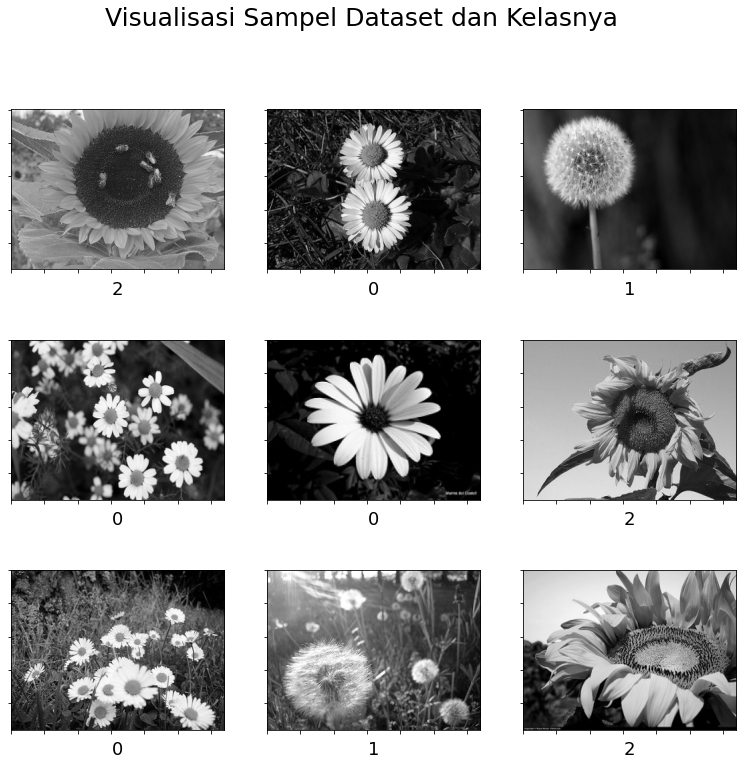

In [24]:
visualize_images(dataset, target, sd=88)

Berikut adalah visualisasi Image Histogram untuk salah satu daisy:

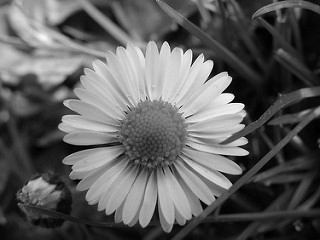

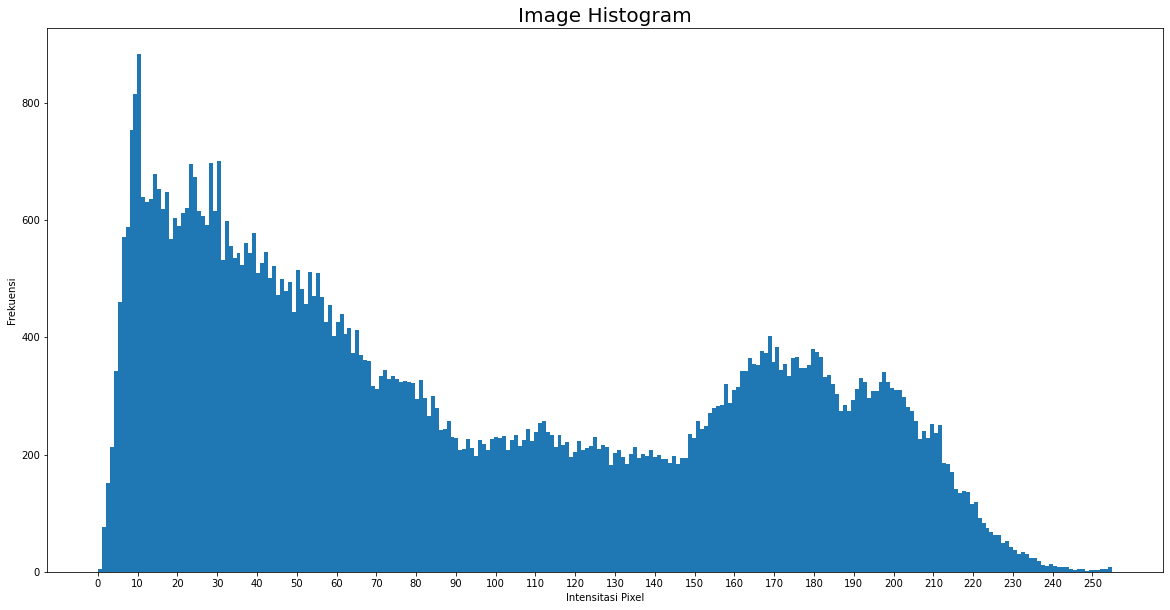

In [25]:
visualize_histogram(daisy_preprocessed[1])

Berikut adalah visualisasi image histogram untuk rata-rata gambar pada kelas daisy, dandelion, dan sunflower:

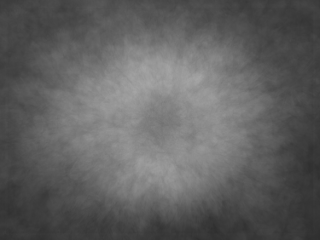

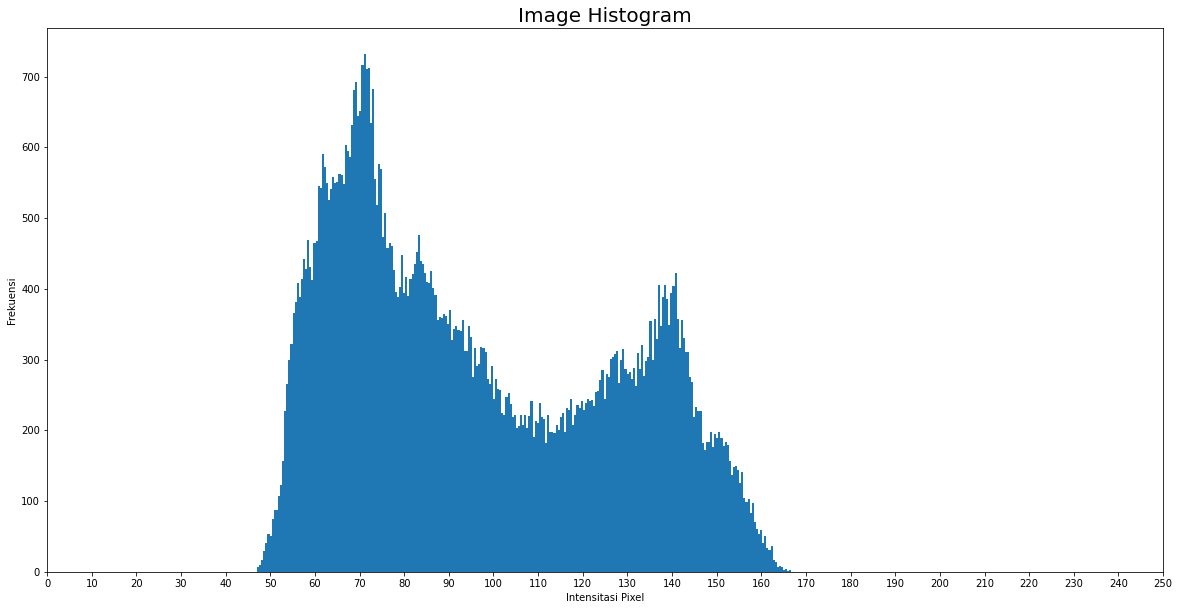

In [26]:
#daisy
visualize_histogram(daisy_preprocessed, multiple=True)

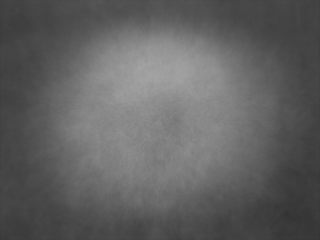

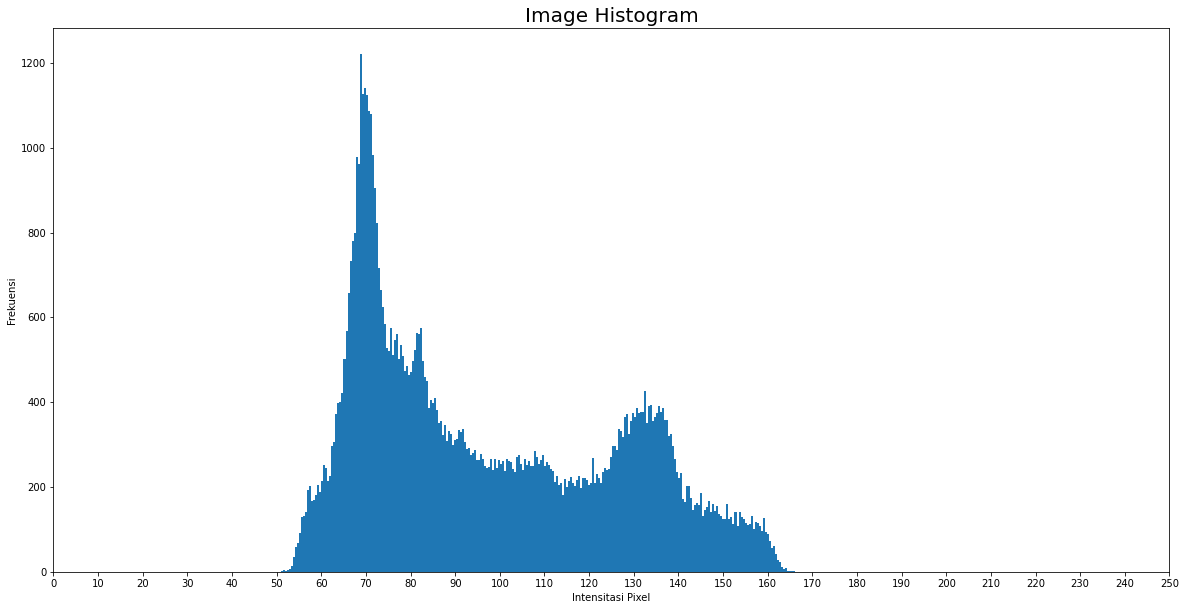

In [27]:
#dandelion
visualize_histogram(dandelion_preprocessed, multiple=True)

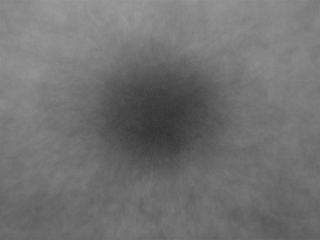

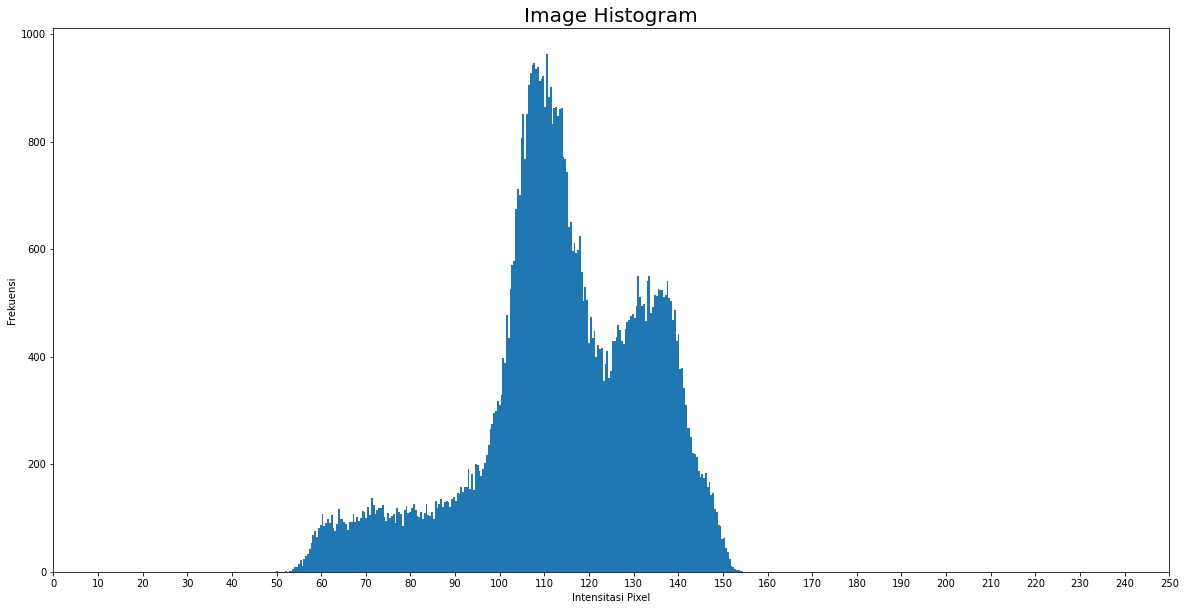

In [28]:
#sunflower
visualize_histogram(sunflower_preprocessed, multiple=True)

Setiap gambar dalam dataset dibuat menjadi satu dimensi agar dapat dimasukkan sebagai input MLP.

In [29]:
dataset = flatten(dataset)

dataset dipecah menjadi data latih (80%) dan data uji (20%)

In [30]:
data_train, data_test, target_train, target_test = split_balance(dataset, 0.8, 
                                                                 target, shuffle=True, seed=88)

Pertama akan dilakukan training dengan MLP dengan jumlah neuron hidden layer 128, epoch 50, dan learning rate 0.1

In [31]:
# learning rate 0.1
MLP = initialization([input_size, 128, 3], seed=42)
loss_history, val_loss_history, acc_history, val_acc_history = train(MLP, data_train, 
                                                                     target_train, data_test, target_test, 50, 0.1)

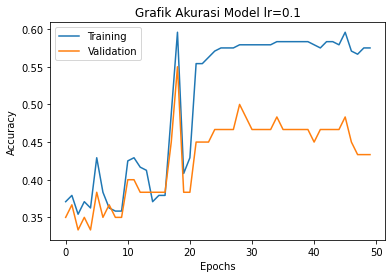

In [32]:
label1 = "Training"
label2 = "Validation"
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Grafik Akurasi Model lr=0.1")
plt.plot(acc_history, label=label1)
plt.plot(val_acc_history, label=label2)
plt.legend()
plt.show()

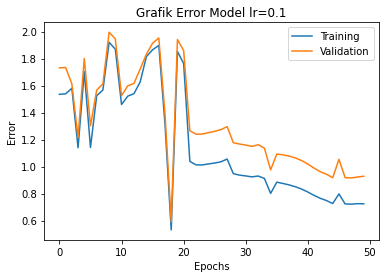

In [33]:
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Grafik Error Model lr=0.1")
plt.plot(loss_history, label=label1)
plt.plot(val_loss_history, label=label2)
plt.legend()
plt.show()

Lalu akan dilakukan training dengan MLP dengan jumlah neuron hidden layer 128, epoch 50, dan learning rate 0.8

In [ ]:
# learning rate 0.8
MLP2 = initialization([input_size, 128, 3], seed=42)
loss_history2, val_loss_history2, acc_history2, val_acc_history2 = train(MLP2, data_train, 
                                                                     target_train, data_test, target_test, 50, 0.8)

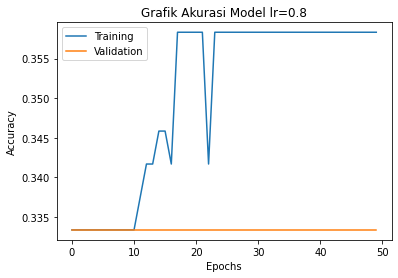

In [35]:
label1 = "Training"
label2 = "Validation"
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Grafik Akurasi Model lr=0.8")
plt.plot(acc_history2, label=label1)
plt.plot(val_acc_history2, label=label2)
plt.legend()
plt.show()

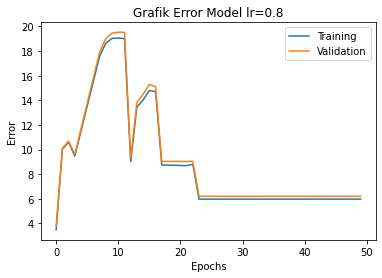

In [36]:
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Grafik Error Model lr=0.8")
plt.plot(loss_history2, label=label1)
plt.plot(val_loss_history2, label=label2)
plt.legend()
plt.show()

Hasil yang didapat terlihat kurang baik. Akurasi masih rendah dan loss besar, dan sangat fluktuatif. Maka dicoba melakukan peningkatan performa dengan menggunakan inisialisasi bobot xavier dan learning rate 0.001

In [40]:
# learning rate 0.001, xavier initialization
MLP3 = initialization([input_size, 128, 3], seed=42)
loss_history3, val_loss_history3, acc_history3, val_acc_history3 = train(MLP3, data_train, 
                                                                     target_train, data_test, target_test, 50, 0.001)

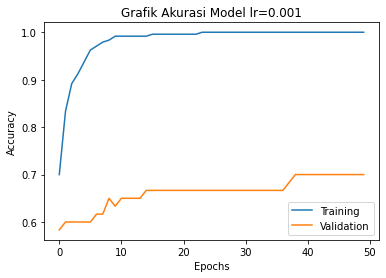

In [41]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Grafik Akurasi Model lr=0.001")
plt.plot(acc_history3, label=label1)
plt.plot(val_acc_history3, label=label2)
plt.legend()
plt.show()

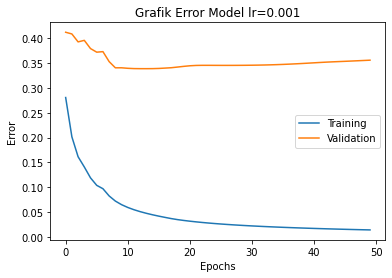

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Grafik Error Model lr=0.001")
plt.plot(loss_history3, label=label1)
plt.plot(val_loss_history3, label=label2)
plt.legend()
plt.show()

Terlihat ada peningkatan: loss berkurang, dan akurasi meningkat. Namun sudah terlihat indikasi overfitting pada data train. Beberapa hal yang dapat dilakukan adalah menambah data latih (karena yang sekarang digunakan hanya sedikit) dan regulariasasi.



---

